In [1]:
%load_ext watermark
%watermark -a "Bhavya Kohli" -v

Author: Bhavya Kohli

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.30.0



# MoNuSAC Instance Segmentation

<a class = "anchor" id="datalink"></a>
This notebook aims to create a Mask-RCNN model using the MoNuSAC data available [**here**](https://monusac-2020.grand-challenge.org/Data/). Due to deprecation issues it is recommended to run this notebook in a virtual environment following the steps described in this [**README**](https://github.com/BhavyaKohli/MoNuSAC-Instance-Segmentation) (available in the repository).

# Contents <a id="top"></a>

1. [Extracting the Data](#extraction)
2. [Exploring the Extracted Data](#exploration)
3. [Using the Mask-RCNN model on the Data](#ml) <br>
    3.1. [Defining the Dataset class](#def_dataset) <br>
    3.2. [Defining the Model Configuration](#def_config) <br>
    3.3. [Defining the Model](#def_model) <br>
    3.4. [Analysis of the trained model](#analysis) <br>

We first confirm the versions of the main libraries, i.e. tensorflow (should be 1.15.0), keras (should be 2.2.5) and h5py (should be 2.10.0). 

In [2]:
%watermark -p tensorflow,keras,h5py

tensorflow: 1.15.0
keras     : 2.2.5
h5py      : 2.10.0



Using TensorFlow backend.


We then run the following cell to silence tensorflow deprecation warnings, since most of the functions and utilities used internally in the mask-rcnn library are deprecated  

In [1]:
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

After downloading the MoNuSAC data mentioned [here](#datalink), extract it to the same directory as the `monusac.ipynb` notebook
The structure of the working directory at this point should be:
```
.
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```

In [2]:
# Importing required libraries
import os, glob, pathlib
import numpy as np                      
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import skimage

# For creating progress bars for "for" loops
import tqdm.notebook as tq          

A separate python file containing all created utility functions has been created. We import all those functions using the following cell:  

In [3]:
from monusac_utils import *

Using TensorFlow backend.


## Extracting the Data <a id="extraction"></a>
[Back to top](#top)

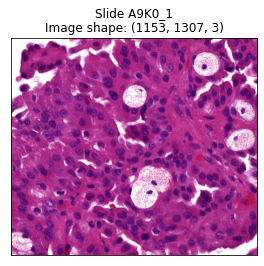

In [4]:
# Displaying a slide image using the above defined function
# using the sample slides in the sample_original directory.
sample_slides = glob.glob('./sample_original/*.svs')
_,ax = plt.subplots()
img = from_svs(sample_slides[0], True, ax)

In [5]:
# Using the above defined function to store masks, slides, and annotations for
# 5 patients in the "data" folder (using default arguments)
data_path = './MoNuSAC_images_and_annotations/'
generate_and_save_masks(RESET = False, 
                        slides = True,
                        masks = True, 
                        annots = True
                        )

Directory ./data/ already exists
Destination directories already exist. Please rename or delete in case of conflicting names.
209 slides were copied to ./data/slides
394 masks were created at ./data/masks
209 annotations were copied to ./data/annots


After running the above cell, the working directory should now have the following structure:

```
.
├───data
│   ├───annots
│   ├───masks
│   │   ├───1
│   │   ├───2
│   │   ├───3
│   │   ├───4
│   │   └───X
│   └───slides
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```



In [6]:
# We create three lists containing paths for slides, masks and annotations.
# We can use these lists for creating plots for visualizing our data and the
# masks created using the `generate_and_save_masks` function
SLIDES_DIR = './data/slides/'
MASKS_DIR = './data/masks/'
ANNOTS_DIR = './data/annots/'
label_mapping = {1: 'Epithelial', 2: 'Lymphocyte', 3: 'Macrophage', 4: 'Neutrophil'}

SLIDES = [SLIDES_DIR + filename for filename in os.listdir('./data/slides')]
PATIENT_IDS = [slide[-10:-4] for slide in SLIDES]

MASKS_TYPE = dict()
MASKS_ALL = []
for i in np.arange(1,5): 
    MASKS_TYPE[i] =  [MASKS_DIR + str(i) + '/' + filename for filename in [x[2] for x in os.walk('./data/masks')][i]]
    MASKS_ALL = MASKS_ALL + MASKS_TYPE[i]

ANNOTS = [ANNOTS_DIR + filename for filename in os.listdir('./data/annots')]

## Exploring the extracted data <a id="exploration"></a>
[Back to top](#top)

In [7]:
find_in_list('7760_1', MASKS_ALL)

['./data/masks/2/Lymphocyte_7760_1.png',
 './data/masks/4/Neutrophil_7760_1.png']

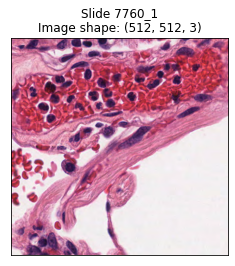

In [8]:
show_slide(find_in_list('7760_1', SLIDES)[0], plt.subplots()[1])

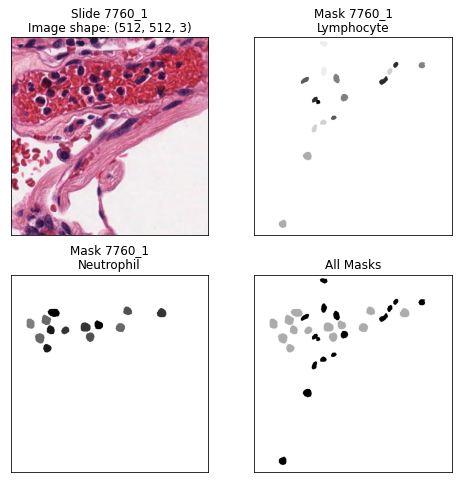

In [9]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('7760_1', SLIDES)[0], axes[0,0])
example_list = find_in_list('7760_1', MASKS_ALL)
for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, axes[loc])
    #tif_show(i, axes[loc])
     
mask_1 = modify_mask_values(plt.imread(example_list[0]), 0.7)
mask_2 = modify_mask_values(plt.imread(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

In [10]:
find_in_list('1594_1', MASKS_ALL)

['./data/masks/1/Epithelial_1594_1.png',
 './data/masks/2/Lymphocyte_1594_1.png']

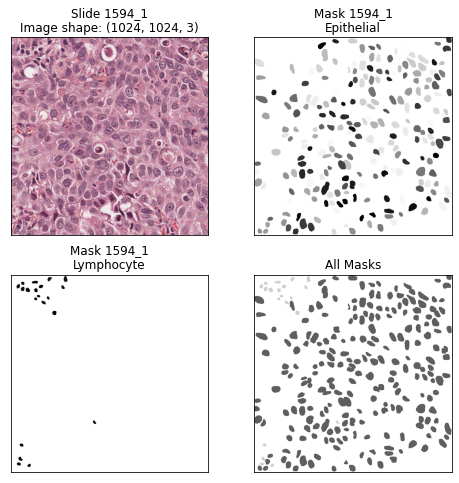

In [11]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('1594_1', SLIDES)[0], axes[0,0])
example_list = find_in_list('1594_1', MASKS_ALL)
for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, axes[loc])
     
mask_1 = modify_mask_values(plt.imread(example_list[0]), 0.7)
mask_2 = modify_mask_values(plt.imread(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

## Using the Mask-RCNN model on the data <a id="ml"></a>
[Back to top](#top)

In [12]:
# Importing required utilities from the mask-rcnn library
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn import visualize
import imgaug

MODEL_WEIGHTS_PATH = '../mask_rcnn_coco.h5'  # loads model weights using this
LOGS_PATH = './logs'                         # saves logs and checkpoint model weights in this directory

### Defining the dataset class <a id="def_class"></a>

We now define the dataset class which inherits the base class utils.Dataset from the library. The load function is the basic function which will have to be run each time a dataset is created using this class. It adds all the necessary information about images such as image id, location of annotations, location of slides, etc. to the dataset. All these will then be used in the load_mask and load_image functions (internally) to add the images themselves to the dataset.

In [13]:
class MonuData(utils.Dataset):
    ANNOTS_DIR = './data/annots/'
    MASKS_DIR = './data/masks/'
    SLIDES_DIR = './data/slides/'

    def load(self, train):
        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        slides_list_total = os.listdir(SLIDES_DIR)
        slides_list = []
        for i in tq.trange(len(PATIENT_IDS)):
            n = num_cells(PATIENT_IDS[i], ANNOTS_DIR)
            if n < 150:
                slides_list.append(slides_list_total[i])

        train_len = int(0.8 * len(slides_list))

        for filename, idx in zip(slides_list, np.arange(len(slides_list))):
            image_id = idx
            patient_id = filename[:-4] 
            img_path = SLIDES_DIR + filename
            annot_path = ANNOTS_DIR + patient_id + '.xml'

            if train and idx > train_len:
                continue
            if not train and idx < train_len + 1:
                continue
            
            self.add_image('cell', 
                           image_id = image_id, 
                           patient_id = patient_id, 
                           path = img_path, 
                           annotation = annot_path)
    
    def load_image(self, image_id, display = False, ax = None):
        info = self.image_info[image_id]
        slide_path = info['path']
        img = show_slide(slide_path, None, display = False, return_img = True)
        return img

    def load_mask(self, image_id, return_counts = False):
        global label_map
        
        label_map = {
            'Epithelial': 1,
            'Lymphocyte': 2,
            'Macrophage': 3,
            'Neutrophil': 4
        }

        info = self.image_info[image_id]

        if info["source"] != 'cell':
            return super(self.__class__, self).load_mask(image_id)

        id = info['patient_id']
        annotations_path = info['annotation']

        tree = ET.parse(annotations_path)
        root = tree.getroot()
        img = self.load_image(image_id)
        masks = dict()
        labels = []
        cell_count = [0,0,0,0,0]

        count = 0
        for k in range(len(root)):
            for child in root[k]:
                for x in child:
                    r = x.tag
                    if r == 'Attribute':
                        label = x.attrib['Name']
                        label_id = label_map[label]

                    if r == 'Region':
                        binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8)

                        vertices = x[1]
                        coords = np.zeros((len(vertices), 2))
                        for i, vertex in enumerate(vertices):
                            coords[i][0] = vertex.attrib['X']
                            coords[i][1] = vertex.attrib['Y']

                        vertex_row_coords = coords[:,0]
                        vertex_col_coords = coords[:,1]

                        fill_row_coords, fill_col_coords = skimage.draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)

                        binary_mask[fill_row_coords, fill_col_coords] = 1
                        masks[count] = (binary_mask, label_id)
                        labels.append(label_id)
                        cell_count[label_id] += 1
                        count += 1
                        
        keys = list(masks.keys())
        net_mask = masks[keys[0]][0]
        net_labels = [masks[keys[0]][1]]
        for key in keys[1:]:
            net_mask = np.concatenate((net_mask, masks[key][0]), axis = 2)
            net_labels.append(masks[key][1])

        #print(net_mask.shape)
        #print(np.dsplit(net_mask, net_mask.shape[2]).shape)
        
        if not return_counts: return net_mask.astype(np.bool_), np.array(net_labels)
        else: return net_mask.astype(np.bool_), np.array(net_labels), cell_count

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#

In [14]:
# Creating the training dataset
train_dataset = MonuData()
train_dataset.load(train = True)
train_dataset.prepare()

# Creating the validation dataset
val_dataset = MonuData()
val_dataset.load(train = False)
val_dataset.prepare()

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

In [15]:
# Confirming that the load_mask function works as intended
load_mask_test = train_dataset.load_mask(2)
print(f"Shape of created mask: {load_mask_test[0].shape}", 
      f"Types of masks created: {np.unique([label_mapping[i] for i in load_mask_test[1]])}",
      f"Total number of individual cells: {load_mask_test[0].shape[2]}",
      f"Info about the image: {train_dataset.image_info[2]}", sep = '\n')

print(f"Total matches for the corresponding patient id in the masks archive:\n {find_in_list(train_dataset.image_info[2]['patient_id'], MASKS_ALL)}")

Shape of created mask: (512, 512, 64)
Types of masks created: ['Epithelial' 'Lymphocyte']
Total number of individual cells: 64
Info about the image: {'id': 2, 'source': 'cell', 'path': './data/slides/1594_5.png', 'patient_id': '1594_5', 'annotation': './data/annots/1594_5.xml'}
Total matches for the corresponding patient id in the masks archive:
 ['./data/masks/1/Epithelial_1594_5.png', './data/masks/2/Lymphocyte_1594_5.png']


As we can see above, masks for 2 types of cells are created using the train_dataset.load_mask function for that image, and there are exactly 2 types of cells whose masks are stored in MASKS_ALL (paths)

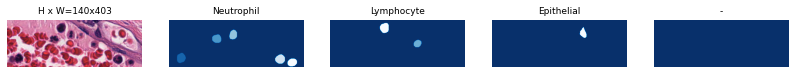

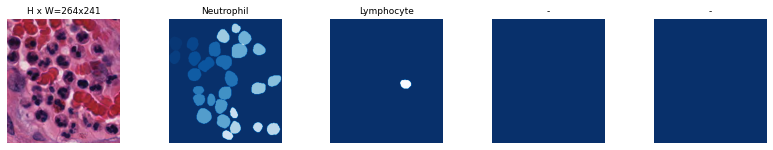

In [16]:
# Visualizing masks for a few slides using the "visualize" utility
# image_ids = np.random.choice(train_dataset.image_ids, 2)
for image_id in [8,11]:
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names)

### Defining the model configuration <a id="def_config"></a>

We inherit the base configuration class from mrcnn.config and override the default values according to the specs of our dataset. We have 4 cell types and so the number of classes have to be set to **5**, which is 1 (background) + 4 (number of unique cell types). Image minimum and maximum dimensions have been set to 1024 each, to have a greater resolution during training, which would result in better results. Minimum detection confidence has been set to 80% for training.

In [17]:
class MonuConfig(Config):
    NAME = 'MoNuSAC'

    IMAGES_PER_GPU = 1              
    NUM_CLASSES = 1 + 4             # Background + 4 cell types
    STEPS_PER_EPOCH = len(train_dataset.image_ids)   
    VALIDATION_STEPS = len(val_dataset.image_ids)
    
    DETECTION_MIN_CONFIDENCE = 0.8  # Setting minimum confidence to 80%
    IMAGE_MIN_DIM = 640             # Minimum image size
    IMAGE_MAX_DIM = 640            # Maximum image size

cfg = MonuConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Defining the model and training it using the datasets created <a id="def_model"></a>

In [25]:
# MODEL_WEIGHTS_PATH = find_in_list('0005', [x.__str__() for x in pathlib.Path('./logs').glob('**/*')])[0]
# For continuing training, load the weights of the best saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)

model.load_weights(
    MODEL_WEIGHTS_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
)

In [26]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = 5*cfg.LEARNING_RATE, 
    epochs = 5, 
    layers = '5+'
)


Starting at epoch 0. LR=0.005

Checkpoint Path: ./logs\monusac20211209T1917\mask_rcnn_monusac_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fp

C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
101/101 [==============================] - 664s 7s/step - loss: 2.6323 - rpn_class_loss: 0.3037 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.8744 - mrcnn_bbox_loss: 0.4962 - mrcnn_mask_loss: 0.4237 - val_loss: 1.6236 - val_rpn_class_loss: 0.1436 - val_rpn_bbox_loss: 0.3251 - val_mrcnn_class_loss: 0.5557 - val_mrcnn_bbox_loss: 0.3173 - val_mrcnn_mask_loss: 0.2820
Epoch 2/5
101/101 [==============================] - 177s 2s/step - loss: 1.8499 - rpn_class_loss: 0.1810 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.6415 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.2785 - val_loss: 1.7556 - val_rpn_class_loss: 0.0998 - val_rpn_bbox_loss: 0.4581 - val_mrcnn_class_loss: 0.5888 - val_mrcnn_bbox_loss: 0.3510 - val_mrcnn_mask_loss: 0.2579
Epoch 3/5
101/101 [==============================] - 189s 2s/step - loss: 1.6419 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.4012 - mrcnn_class_loss: 0.5802 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.2661 - val_loss: 1.5444 - val_rpn_class_loss

In [18]:
# Using the model weights from the latest run to continue training. 
MODEL_WEIGHTS_PATH = find_in_list('0004', [x.__str__() for x in pathlib.Path('./logs').glob('**/*')])[-1]

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)
model.load_weights(MODEL_WEIGHTS_PATH, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 4


In [20]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = cfg.LEARNING_RATE, 
    epochs = 15, 
    layers = '5+'
)


Starting at epoch 6. LR=0.001

Checkpoint Path: ./logs\monusac20211209T1917\mask_rcnn_monusac_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fp

C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 7/15
101/101 [==============================] - 184s 2s/step - loss: 1.0647 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.1939 - mrcnn_mask_loss: 0.2207 - val_loss: 1.2865 - val_rpn_class_loss: 0.0995 - val_rpn_bbox_loss: 0.3220 - val_mrcnn_class_loss: 0.3783 - val_mrcnn_bbox_loss: 0.2329 - val_mrcnn_mask_loss: 0.2538
Epoch 8/15
101/101 [==============================] - 175s 2s/step - loss: 0.9838 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.3251 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.2196 - val_loss: 1.3569 - val_rpn_class_loss: 0.1106 - val_rpn_bbox_loss: 0.3529 - val_mrcnn_class_loss: 0.4179 - val_mrcnn_bbox_loss: 0.2242 - val_mrcnn_mask_loss: 0.2512
Epoch 9/15
101/101 [==============================] - 183s 2s/step - loss: 0.9445 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.3184 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2127 - val_loss: 1.3446 - val_rpn_class_l

### Further analysis and visualizations using the trained model <a id="analysis"></a>

In [21]:
from collections import Counter

In [22]:
# Defining a new configuration for Inference
class InferenceConfig(cfg.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

inf_cfg = InferenceConfig()
inf_cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [23]:
find_in_list('0013', [x.__str__() for x in pathlib.Path(LOGS_PATH).glob('**/*')])

['logs\\monusac20211205T0107\\mask_rcnn_monusac_0013.h5',
 'logs\\monusac20211209T1917\\mask_rcnn_monusac_0013.h5']

In [24]:
# Using the model weights from the 5th epoch of the latest run for model evaluation.
WEIGHTS_PATH = find_in_list('0013', [x.__str__() for x in pathlib.Path('./logs').glob('**/*')])[-1]

# Defining model in 'inference' mode
model_trained = MaskRCNN(mode = 'inference', config = inf_cfg, model_dir = LOGS_PATH)
model_trained.load_weights(WEIGHTS_PATH, by_name = True)

Re-starting from epoch 13


{'id': 119, 'source': 'cell', 'path': './data/slides/AA11_6.png', 'patient_id': 'AA11_6', 'annotation': './data/annots/AA11_6.xml'}
image ID: 18, cell-119 ./data/slides/AA11_6.png
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


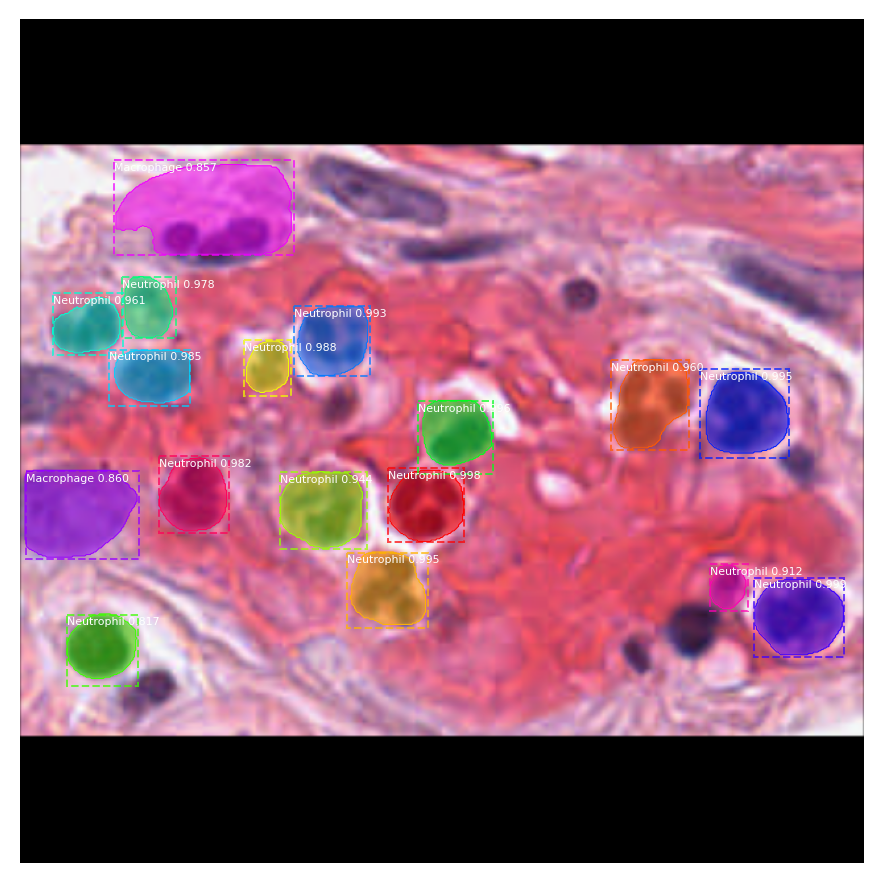

In [25]:
image_id = 18 #np.random.choice(val_dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(val_dataset, inf_cfg, image_id, use_mini_mask=True)
info = val_dataset.image_info[image_id]
print(f"image ID: {image_id}, {info['source']}-{info['id']} {val_dataset.image_reference(image_id)}")
image_x, image_y = image.shape[:2]

#image = image[:image_x//2,:image_y//2]
results = model_trained.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], val_dataset.class_names, r['scores'])

In [26]:
result_classes = dict(Counter([label_mapping[id] for id in r['class_ids']]))
print(
    f"Cell types detected : {result_classes}",
    f"Number of cells detected : {np.sum([result_classes[key] for key in result_classes.keys()])}",
    f"Types of masks in main directory : {find_in_list(val_dataset.image_info[image_id]['patient_id'], MASKS_ALL)}",
    f"Actual number of cells : {num_cells(val_dataset.image_info[image_id]['patient_id'], ANNOTS_DIR)}", sep = '\n'
)

Cell types detected : {'Neutrophil': 15, 'Macrophage': 2}
Number of cells detected : 17
Types of masks in main directory : ['./data/masks/2/Lymphocyte_AA11_6.png', './data/masks/4/Neutrophil_AA11_6.png']
Actual number of cells : 14


## Misc. Testing

In [59]:
find_in_list('7220_1', MASKS_ALL)

['./data/masks/2/Lymphocyte_7220_1.tif',
 './data/masks/3/Macrophage_7220_1.tif',
 './data/masks/4/Neutrophil_7220_1.tif']

In [60]:
annotations_path = './data/annots/1594_1.xml'
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }
            
tree = ET.parse(annotations_path)
root = tree.getroot()
cell_count = [0,0,0,0,0]

img = from_svs('./ignore/data_backup/slides/1594_1.svs')
masks = dict()
#{'Epithelial':dict(),
 #        'Lymphocyte':dict(),
  #       'Macrophage':dict(),
   #      'Neutrophil':dict(),
    #    }
labels = []
l = dict()
unique = 0
count = 0
for k in range(len(root)):
    for child in root[k]:
        l_temp = dict()
        for x in child:
            r = x.tag
            if r == 'Attribute':
                label = x.attrib['Name']

            if r == 'Region':
                binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8) 
                idx = cell_count[label_map[label]]
                vertices = x[1]
                coords = np.zeros((len(vertices), 2))
                for i, vertex in enumerate(vertices):
                    coords[i][0] = vertex.attrib['X']
                    coords[i][1] = vertex.attrib['Y']

                vertex_row_coords = coords[:,0]
                vertex_col_coords = coords[:,1]

                fill_row_coords, fill_col_coords = skimage.draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                unique += 0.4
                binary_mask[fill_row_coords, fill_col_coords] = unique                

                l_temp[unique] = label_map[label]
                #print(l_temp)
                masks[count] = (binary_mask, label_map[label])
                labels.append(label_map[label])
                cell_count[label_map[label]] += 1
                count += 1
            l[count] = l_temp

In [16]:
from PIL import Image

In [60]:
def split_image(self, patient_id, annots_dir = ANNOTS_DIR):
    cell_count = num_cells(patient_id, annots_dir)
    image_path = find_in_list(patient_id, SLIDES)
    image = from_svs(image_path)
    x, y, _ = image.shape

    slices = []
    while cell_count > 50:
        x, y = x//2, y//2
        slices += [image[:x,:y], image[x:,:y], image[x:,:y], image[x:,y:]]
        counts = a

64


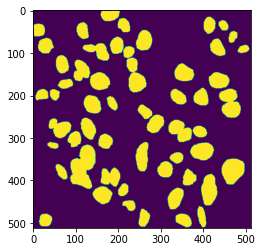

In [18]:
m = train_dataset.load_mask(2)[0]
plt.imshow(combine_masks(m))

In [22]:
np.savetxt('txt.txt', m.flatten())

In [19]:
import pandas as pd
import feather

In [39]:
feather.write_dataframe(pd.DataFrame(m.flatten()), 'txt.feather')

64


  0%|          | 0/63 [00:00<?, ?it/s]

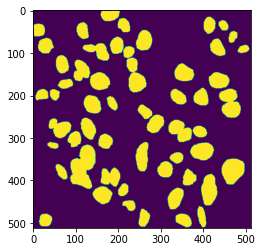

In [42]:
plt.imshow(combine_masks(feather.read_dataframe('txt.feather').values.reshape(m.shape)))

In [22]:
masks = crop_mask(m, 128, 128)

In [24]:
masks['00'].shape

(128, 128, 64)

In [ ]:
masks = crop_mask(m, 128, 128)
_, axes = plt.subplots(4, 4, figsize = (7,7))

for i, j in zip(masks.keys(), [(i,j) for i in np.arange(4) for j in np.arange(4)]):
    clean_plot(combine_masks(masks[i]), axes[j], cmap = "Blues")

64


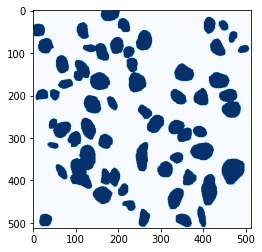

In [26]:
plt.imshow(combine_masks(m), cmap = "Blues")

In [62]:
def split(image, mask, patient_id, train, out_dir, height, width):
    """
    Splits the input image and mask into smaller parts of shape determined
    by the "height" and "width" arguments \n

    Arguments: \n
    image - numpy array of shape (X,Y,3), contains the image of a slide 
            as an array \n
    mask - numpy array of shape (X,Y,N), contains the corresponding mask 
           of the image argument \n
    patient_id - string, the corresponding patient id for the image and mask
                 described above \n
    train - bool, determines whether to create the "train" or "val" sub-directory \n
    height, width - integers, determine the shape of the output images \n

    All smaller images are saved using the _00, _01,... suffixes after the 
    patient_id.
    """
    image_dir = os.path.join(out_dir, 'train/slides') if train else os.path.join(out_dir, 'val/slides')
    mask_dir = os.path.join(out_dir, 'train/masks') if train else os.path.join(out_dir, 'val/masks')

    for i, piece in enumerate(crop_image(image, height, width)):
        img = Image.new('RGB', (height, width))
        img.paste(piece)
        img_path = os.path.join(image_dir , patient_id + '_' + str(i).zfill(2) + '.png')
        img.save(img_path)

    cropped_masks = crop_mask(mask, height, width)

    for i, key in zip(range(len(cropped_masks)), cropped_masks):
        msk_path = os.path.join(mask_dir, patient_id + '_' + str(i).zfill(2) + '.feather')
        mask_1d = cropped_masks[key].flatten()

        feather.write_dataframe(pd.DataFrame(mask_1d), msk_path)

In [63]:
def create_train_test_data(slides_dir, train, train_size, out_dir, RESET = False):
    """
    Creates the following directories in the root directory
    1. A directory defined by the "out_dir"  \n
    2. Sub-directories named "train" and "val", dependent on the "train"
       argument inside the created out_dir directory \n
    3. Sub-sub-directories "slides" and "masks" for storing their respective
       types of data \n

    Slides are read from the "slides_dir" directory which were created using
    the generate_and_save_masks function \n

    Arguments: \n
    slides_dir - string, location of all slides in .png format, created using
                 as described above \n
    train - bool, when True, creates the "train" sub-directory and when False,
            creates the "val" sub-directory \n 
    train_size - float value between 0 and 1, determines the relative size of 
                 the training set compared to the complete dataset \n 
    out_dir - string, location where the outputs will be saved \n
    RESET - bool, when True, deletes the existing "out_dir" directory along
            with its contents and creates it from scratch \n
    """     
    if RESET: shutil.rmtree(out_dir)
    
    try: os.mkdir(out_dir)
    except: print(f"Directory {out_dir} exists")

    dir = 'train' if train else 'val'
    dir = os.path.join(out_dir, dir)

    try: os.mkdir(dir)
    except: print(f"Directory {dir} exists")

    image_dir = os.path.join(dir, 'slides')  
    mask_dir = os.path.join(dir, 'masks')      

    try:
        os.mkdir(image_dir)
        os.mkdir(mask_dir)
    except:
        pass

    shapes = []
    train_len = int(train_size * len(PATIENT_IDS))
    patient_ids = PATIENT_IDS[:train_len] if train else PATIENT_IDS[train_len + 1:]

    for patient_id in tq.tqdm(patient_ids):
        slide_path = os.path.join(slides_dir, f'{patient_id}.png')
        slide = show_slide(slide_path, return_img = True, ax = None, display = False)
        mask = load_mask(patient_id)[0]
        shapes.append(mask.shape)
        n =  num_cells(patient_id, ANNOTS_DIR)

        x, y = slide.shape[:2]

        if n > 300:
            split(slide, mask, patient_id, train, out_dir, x//4, y//4)
        if n < 300 and n > 150:
            split(slide, mask, patient_id, train, out_dir, x//2, y//2)
        else:
            split(slide, mask, patient_id, train, out_dir, x, y)

    shapes_dir = os.path.join(dir, 'shapes.feather')
    feather.write_dataframe(pd.DataFrame(shapes), shapes_dir)

In [64]:
create_train_test_data(slides_dir = './data/slides/', train = True, train_size = 0.8, out_dir = './final', RESET = False)
create_train_test_data(slides_dir = './data/slides/', train = False, train_size = 0.8, out_dir = './final', RESET = False)

  0%|          | 0/167 [00:00<?, ?it/s]